# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import random
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

In [3]:
# for simple charting, the below function renames axis and titles which will be called regularly
def pltlab(title,x_label,y_label):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('The rows and columns for the Udacity_AZDIAS_Subset.csv dataset are:', (azdias.shape))
print('The rows and columns for the AZDIAS_Feature_Summary.csv dataset are:', (feat_info.shape))

The rows and columns for the Udacity_AZDIAS_Subset.csv dataset are: (891221, 85)
The rows and columns for the AZDIAS_Feature_Summary.csv dataset are: (85, 4)


In [6]:
# The first five rows of the Udacity_AZDIAS_Subset.csv dataset
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# The first five rows of the AZDIAS_Feature_Summary.csv
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [9]:
# create copy of original data to Convert Missing Value Codes to NaNs
azdias_2 = azdias.copy()

In [10]:
# cycle through Missing Value Codes and use them to go through data columns to replace with nans
for i in range(len(feat_info)):
    colname = feat_info.iloc[i, 0]
    a = feat_info.iloc[i, 3]
    b = pd.DataFrame([a])
    b[0] = b[0].map(lambda x: x.lstrip('[').rstrip(']'))
    b = b[0].str.split(',', expand=True)
    b = b.transpose()
    for j in range(len(b)):
        c = b.iloc[j, 0]
        if c.isnumeric() or c.lstrip('-').isnumeric():
            c = int(c)
        azdias_2.loc[azdias_2[colname] == c, colname] = np.nan
azdias_2.head(10)

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1943.0,1.0,0.0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,NaN,2.0,4.0,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,NaN,12.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,1.0,0.0,NaN,1.0,4.0,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,1964.0,9.0,0.0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,5.0,1.0,1.0,2.0,5.0,5.0,0.0,0.0,NaN,1.0,1.0,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,1974.0,3.0,1.0,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4.0,5.0,4.0,1.0,5.0,6.0,4.0,5.0,2.0

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missdat = azdias_2.isnull().sum().to_frame()
missdat = missdat.rename(columns={0: "number_nans"})
missdat['percent_nans'] = (missdat['number_nans']/azdias_2.shape[0])*100
missdat.head(10)

,number_nans,percent_nans
AGER_TYP,685843,76.955435
ALTERSKATEGORIE_GROB,2881,0.323264
ANREDE_KZ,0,0.000000
CJT_GESAMTTYP,4854,0.544646
FINANZ_MINIMALIST,0,0.000000
FINANZ_SPARER,0,0.000000
FINANZ_VORSORGER,0,0.000000
FINANZ_ANLEGER,0,0.000000
FINANZ_UNAUFFAELLIGER,0,0.000000
FINANZ_HAUSBAUER,0,0.000000


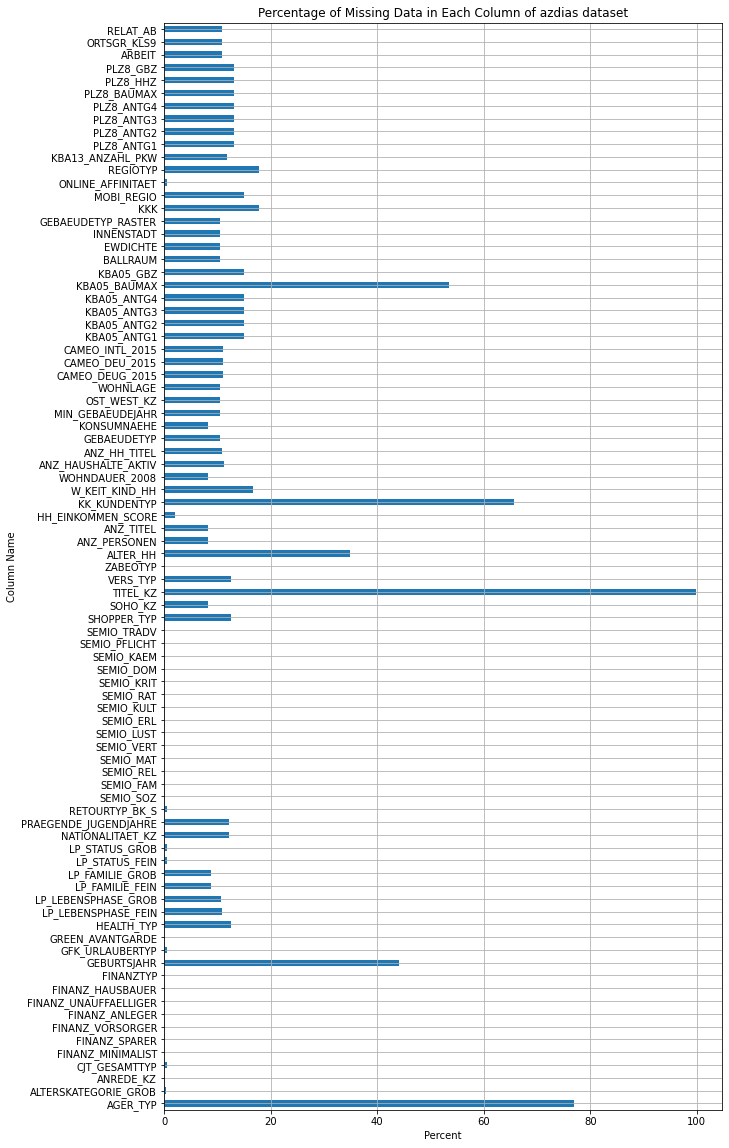

In [12]:
# Investigate patterns in the amount of missing data in each column.
missdat.plot.barh(y='percent_nans', legend=None, figsize=(10, 20))
plt.grid(True)
pltlab('Percentage of Missing Data in Each Column of azdias dataset','Percent','Column Name')

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# 20% or more nan values looks like a good cut-off
coloutlier = missdat[(missdat['percent_nans'] > 20)]
coloutlier = coloutlier.index.to_list()

print("Columns with greater than 20% nan values:", ", ".join(coloutlier))

Columns with greater than 20% nan values: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX


In [14]:
# create copy of pre-processed data to remove outlier columns
azdias_3 = azdias_2.copy()

In [15]:
# Remove columns from copy of nan dataset
for col in coloutlier:
    azdias_3.drop([col], axis=1, inplace=True)

In [16]:
print('Original azdias dataset columns:', azdias.shape[1], '\tModified azdias dataset columns:', azdias_3.shape[1])

Original azdias dataset columns: 85 	Modified azdias dataset columns: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

Calculating the percentage of missing values per column revealed that roughly a third of columns had less than 1% missing values, almost two-thirds had 0-20% missing values and six remaining columns had more than 20% of their values missing. 

As these six columns had such a striking difference in componant missing values compared to the rest, they were viewed as outliers and removed. The names of the columns removed are as follows:
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?

missdatr = azdias_3.isnull().sum(axis=1).to_frame()
missdatr = missdatr.rename(columns={0: "number_nans"})
missdatr['percent_nans'] = (missdatr['number_nans']/azdias_2.shape[1])*100
missdatr.head(10)

,number_nans,percent_nans
0,43,50.588235
1,0,0.000000
2,0,0.000000
3,7,8.235294
4,0,0.000000
5,0,0.000000
6,0,0.000000
7,0,0.000000
8,0,0.000000
9,0,0.000000


In [18]:
print('Number of rows without missing data:', missdatr.number_nans[missdatr.number_nans == 0].count())
print('Number of rows with missing data:', missdatr.number_nans[missdatr.number_nans > 0].count())

Number of rows without missing data: 623209
Number of rows with missing data: 268012


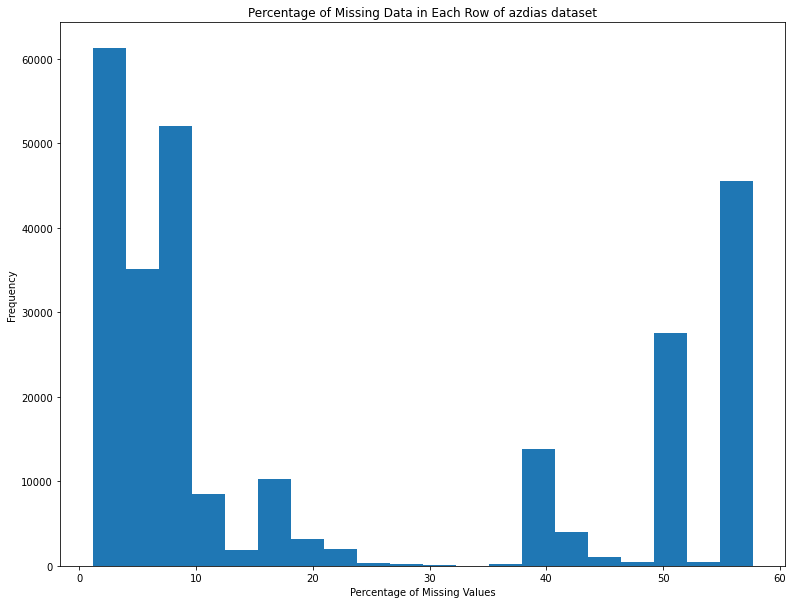

In [19]:
# plot missing data
missdatrab = missdatr[(missdatr['percent_nans'] > 0)]
missdatrab['percent_nans'].plot.hist(bins=20,figsize=(13, 10))
pltlab('Percentage of Missing Data in Each Row of azdias dataset','Percentage of Missing Values','Frequency')

In [20]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# The majority of the data has less than 10% missing value so 10% will be the subset split value
missdatrone = missdatr[(missdatr['percent_nans'] <= 10)]
missdatrtwo = missdatr[(missdatr['percent_nans'] > 10)]
print('Number of rows with less than 10% missing values per row:', missdatrone.shape[0])
print('Number of rows with greater than 10% missing values per row:', missdatrtwo.shape[0])

Number of rows with less than 10% missing values per row: 771701
Number of rows with greater than 10% missing values per row: 119520


In [21]:
# Divide the data into two subsets based on the number of missing values in each row

missdatronedl = azdias_3[azdias_3.index.isin(missdatrone.index)]
missdatronedh = azdias_3[azdias_3.index.isin(missdatrtwo.index)]
print('Number of rows with less than 10% missing values per row:', missdatronedl.shape[0])
print('Number of rows with greater than 10% missing values per row:', missdatronedh.shape[0])

Number of rows with less than 10% missing values per row: 771701
Number of rows with greater than 10% missing values per row: 119520


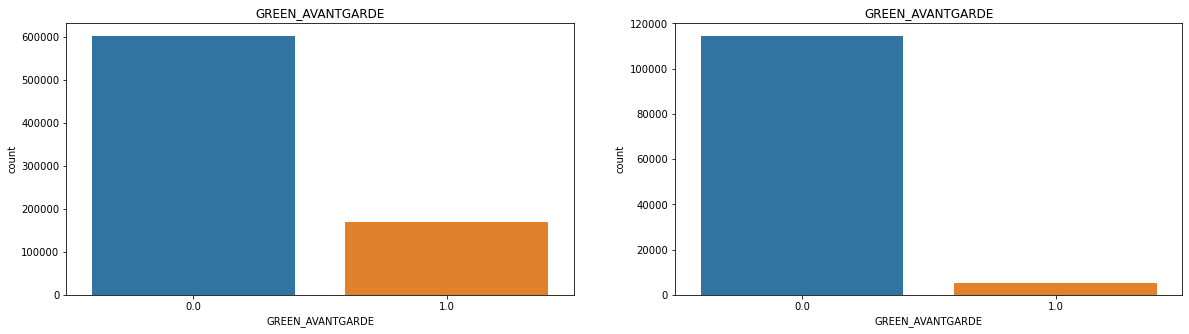

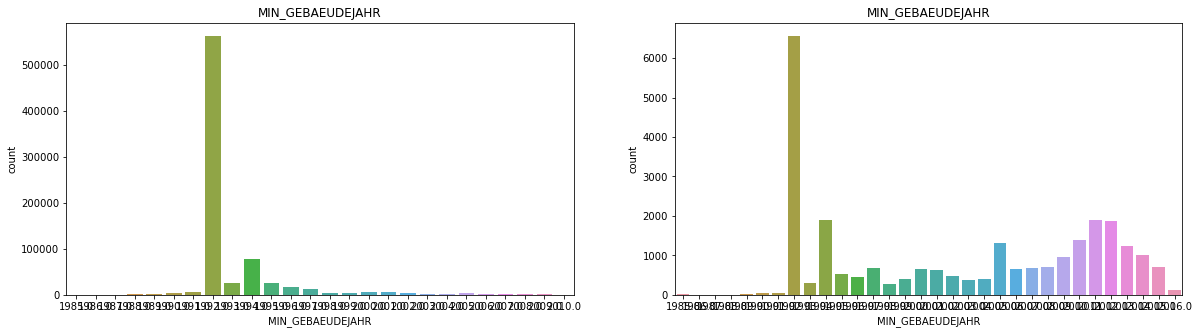

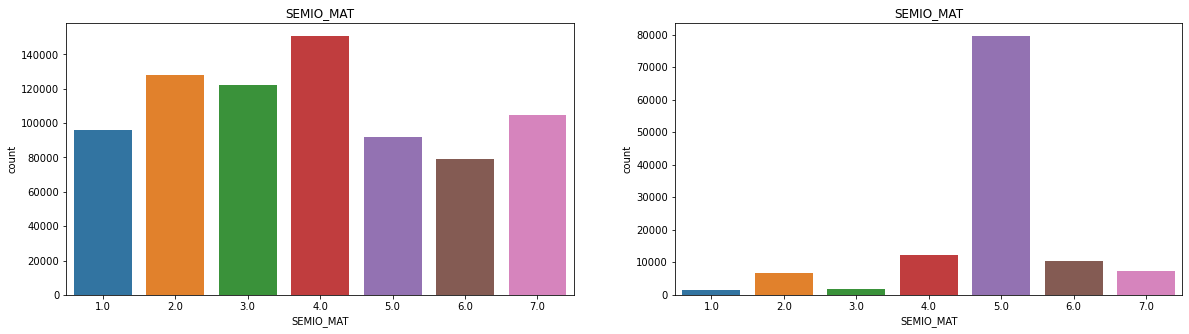

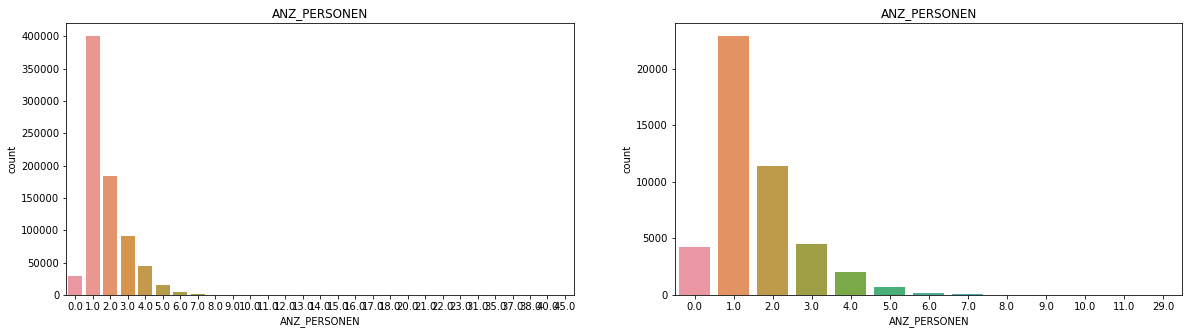

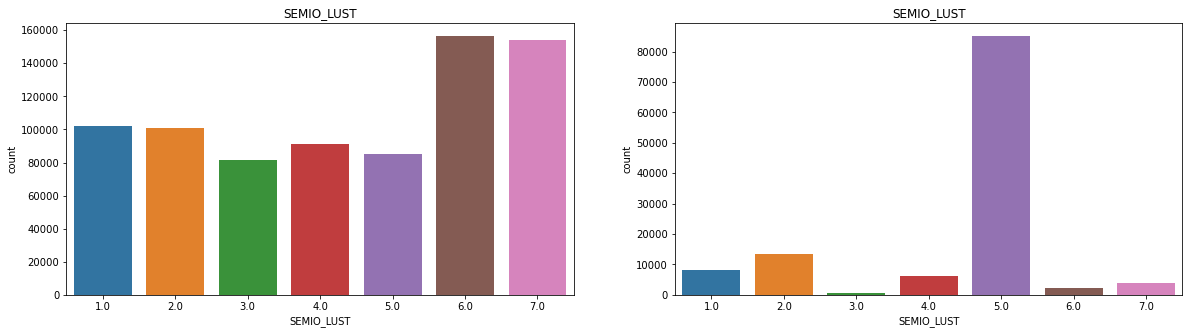

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# randomly select five columns
cols = list(azdias_3)
cols_samp = random.sample(cols, 5)

# plot data
for col in cols_samp:
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    sb.countplot(data = missdatronedl, x = col, ax = ax[0])
    ax[0].set_title(col, fontsize=12)
    sb.countplot(data = missdatronedh, x = col, ax = ax[1])
    ax[1].set_title(col, fontsize=12)

In [23]:
# create copy of subet data with few missing values
azdias_4 = missdatronedl.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

For some variables, there is a distinct difference in the distribution of values comparing the dataset with less than 10% missing values per row and the dataset with greater than 10% missing values per row. However, for other variables there appears to be very little difference. 

It is therefore not possible to make the simple conclusion that the data with numerous missing values should be discarded. The apparent difference in some variables comparing the two datasets suggests both should be carried forward for analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

# Get new feat_info list based on data that has not been removed during pre-processing
feat_info_proc = feat_info[feat_info['attribute'].isin(cols)]

# How many features are there of each data type?
feat_info_proc.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

##### Step 1.2.1.1: Identify non-binary Categorical Features

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify features which are categorical
feat_cat = feat_info_proc[(feat_info_proc['type'] == "categorical")]
feat_cat = feat_cat.attribute.to_list()
feat_cat

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [26]:
binary_cat = []
multi_cat = []
for fact in feat_cat:
    valcount = len(azdias_4[fact].value_counts())
    if valcount > 2:
        multi_cat.append(fact)
    else:
        binary_cat.append(fact)

print("Binary (two-level) categoricals:", ", ".join(binary_cat))
print("Multi-level (three or more values) categoricals:", ", ".join(multi_cat))

Binary (two-level) categoricals: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ
Multi-level (three or more values) categoricals: CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015


In [27]:
# Binary (two-level) categorical which is non-numeric
azdias_4.reindex(binary_cat, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ANREDE_KZ         771701 non-null  float64
 1   GREEN_AVANTGARDE  771701 non-null  float64
 2   SOHO_KZ           771701 non-null  float64
 3   VERS_TYP          739213 non-null  float64
 4   OST_WEST_KZ       771701 non-null  object 
dtypes: float64(4), object(1)
memory usage: 35.3+ MB


In [28]:
# List of categorical variables to be re-encoded
multi_cat.append("OST_WEST_KZ")
multi_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'OST_WEST_KZ']

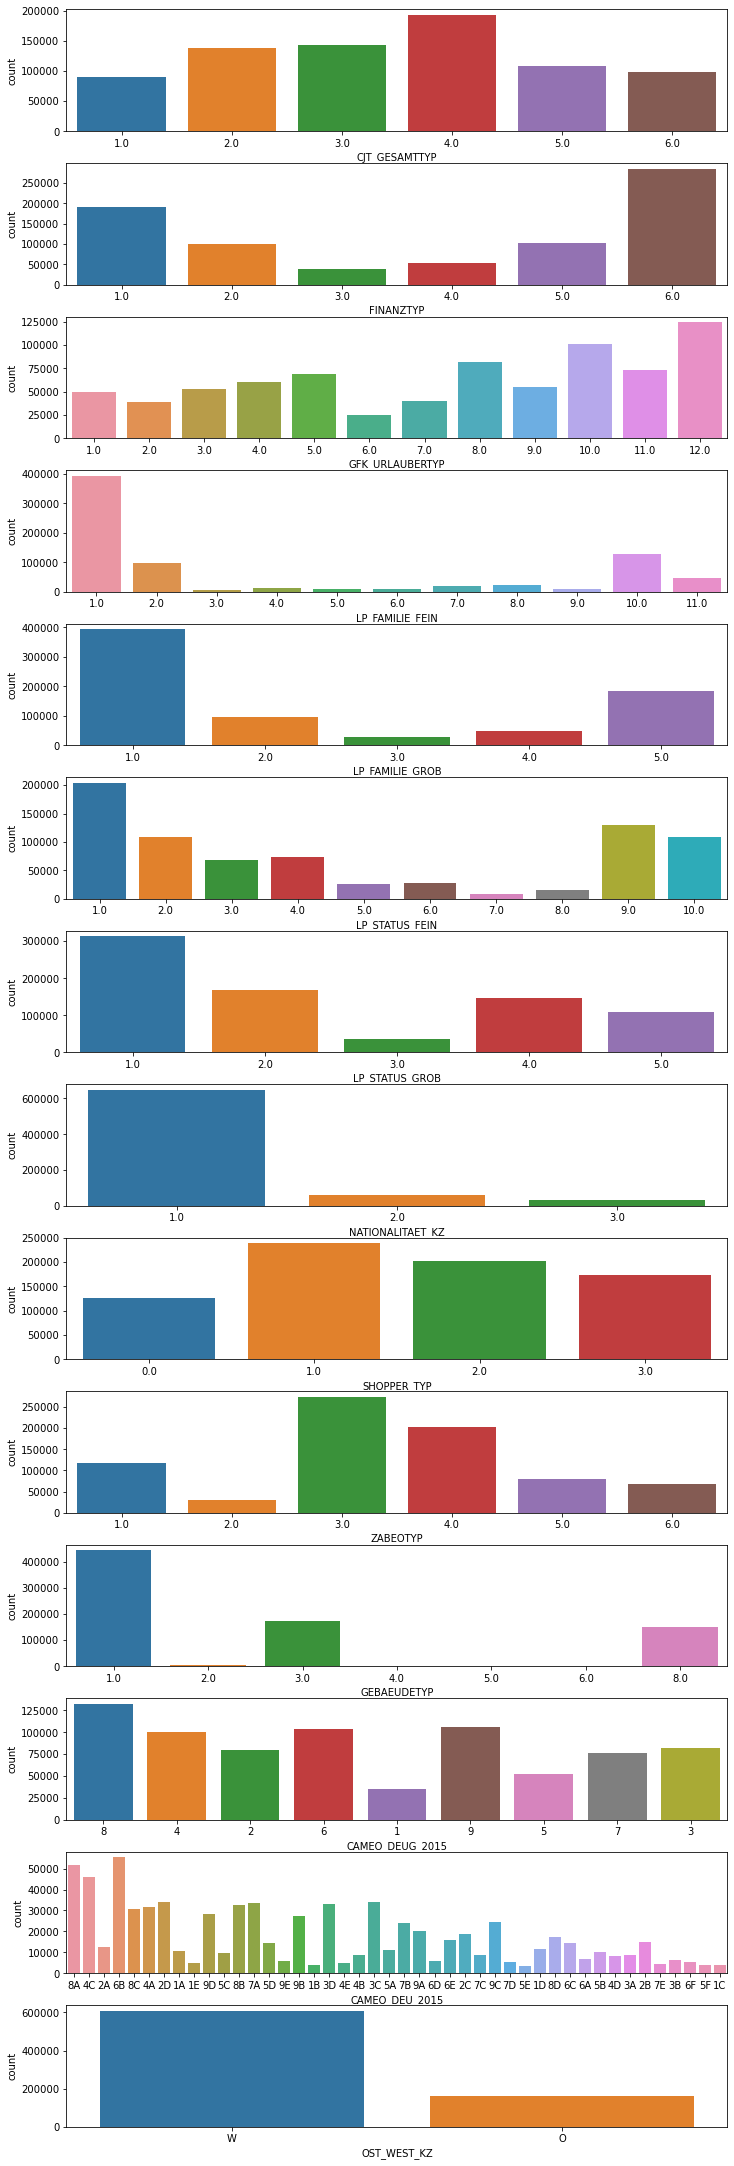

In [29]:
# get data for multi-cat columns in one dataframe
multic = azdias_4.reindex(multi_cat, axis=1)

# plot countplots
fig, ax = plt.subplots(nrows=len(multi_cat), figsize = [10,30])
x = 0
plt.tight_layout()
for c in multi_cat:
    sb.countplot(data = multic, x = c,ax = ax[x])    
    x = x+1

In [30]:
for c in multi_cat:
    print('Percentage of missing values for column', c, "is equal to: ",((multic[c].isnull().sum()/multic[c].shape[0]))*100)

Percentage of missing values for column CJT_GESAMTTYP is equal to:  0.0
Percentage of missing values for column FINANZTYP is equal to:  0.0
Percentage of missing values for column GFK_URLAUBERTYP is equal to:  0.0
Percentage of missing values for column LP_FAMILIE_FEIN is equal to:  3.0708784879117688
Percentage of missing values for column LP_FAMILIE_GROB is equal to:  3.0708784879117688
Percentage of missing values for column LP_STATUS_FEIN is equal to:  0.0
Percentage of missing values for column LP_STATUS_GROB is equal to:  0.0
Percentage of missing values for column NATIONALITAET_KZ is equal to:  3.888163939142233
Percentage of missing values for column SHOPPER_TYP is equal to:  4.209920681714809
Percentage of missing values for column ZABEOTYP is equal to:  0.0
Percentage of missing values for column GEBAEUDETYP is equal to:  0.0
Percentage of missing values for column CAMEO_DEUG_2015 is equal to:  0.4326805330043631
Percentage of missing values for column CAMEO_DEU_2015 is equal

Looking at the above, the following decisions were taken for each variable to decide whether to re-encode or drop:
- CJT_GESAMTTYP - Dropped - Represented preferred information and buying channels for consumer and appeared to have overlap in categories
- FINANZTYP - Dropped - Most descriptive financial type for individual which appeared to be a descriptive interpretation of other data and it is mostly 1 which is Unknown
- GFK_URLAUBERTYP - Kept - Vacation habits was not covered in any other categories
- LP_FAMILIE_FEIN - Dropped - Family type, fine scale - in great detail which is summarised by another attribute
- LP_FAMILIE_GROB - Kept - Family type, rough scale which is a summary of above
- LP_STATUS_FEIN - Dropped - Social status, fine scale - in great detail which is summarised by another attribute
- LP_STATUS_GROB - Kept - Social status, rough scale which is a summary of above
- NATIONALITAET_KZ - Dropped - Dominant value is 1 which is "Unknown"
- SHOPPER_TYP - Dropped - Unknown variables
- ZABEOTYP - Dropped - Energy consumption type disregarded
- GEBAEUDETYP - Kept - Type of building can be easily summarised into two variable as either Residential or Mixed
- CAMEO_DEUG_2015 - Kept - Wealth / Life Stage Typology with a good range of data
- CAMEO_DEU_2015 - DROPPED - Too many categories exploring CAMEO_DEUG_2015 detail
- OST_WEST_KZ- Kept - Can be easily converted to numerics

##### Step 1.2.1.2: Drop un-wanted Categorical Features

In [31]:
# Drop un-wanted attributes from main dataset

drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEU_2015']

# create copy of processed data to remove outlier columns
azdias_5 = azdias_4.copy()

# drop un-wanted attributes from main dataset
for dro in drop:
    azdias_5.drop([dro], axis=1, inplace=True)

##### Step 1.2.1.3: Get Dummies Categorical Features to be kept

In [32]:
# Re-Encode Categorical Features to be kept

# Re-encode GFK_URLAUBERTYP, LP_FAMILIE_GROB, LP_STATUS_GROB and CAMEO_DEUG_2015 using pd.get_dummies
cols = ['GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015']

# make sep df for reencoding
renc = azdias_5[cols]

# ensure all values are ints
renc = renc[cols].fillna(0.0).astype(int)

# get dummies for selected columns
azdias_5_renc = pd.get_dummies(data=renc, columns=cols)

# drop original columns from dataset
for co in cols:
    azdias_5.drop([co], axis=1, inplace=True)

# append dummied columns to dataset
azdias_5 = pd.concat([azdias_5, azdias_5_renc], axis=1, sort=False)
azdias_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   769218 non-null  float64
 1   ANREDE_KZ              771701 non-null  float64
 2   FINANZ_MINIMALIST      771701 non-null  float64
 3   FINANZ_SPARER          771701 non-null  float64
 4   FINANZ_VORSORGER       771701 non-null  float64
 5   FINANZ_ANLEGER         771701 non-null  float64
 6   FINANZ_UNAUFFAELLIGER  771701 non-null  float64
 7   FINANZ_HAUSBAUER       771701 non-null  float64
 8   GREEN_AVANTGARDE       771701 non-null  float64
 9   HEALTH_TYP             739213 non-null  float64
 10  LP_LEBENSPHASE_FEIN    730996 non-null  float64
 11  LP_LEBENSPHASE_GROB    733594 non-null  float64
 12  PRAEGENDE_JUGENDJAHRE  747372 non-null  float64
 13  RETOURTYP_BK_S         771701 non-null  float64
 14  SEMIO_SOZ              771701 non-n

All nans have been filled with 0.

For GFK_URLAUBERTYP, LP_STATUS_GROB and CAMEO_DEUG_2015 this has added an extra class (0) in the attribute which will be termed "Unknown".

For LP_FAMILIE_GROB the extra class of 0 will match the already present class of 0 which is termed "Unknown".

##### Step 1.2.1.4: Re-Encode Categorical Features to be kept - GEBAEUDETYP

In [33]:
# Re-encode GEBAEUDETYP to be kept in the analysis

azdias_5['GEBAEUDETYP'].value_counts()

1.0    442473
3.0    173886
8.0    149937
2.0      4099
4.0       779
6.0       526
5.0         1
Name: GEBAEUDETYP, dtype: int64

3.3. GEBAEUDETYP to be re-encoded from:

Type of building (residential vs. commercial)
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company

To:
-  1: residential building
-  3: mixed building

In [34]:
# create dictionary
GEBAEUDETYP_d = {1.0: 1, 2.0: 1, 3.0: 3, 4.0: 3, 5.0: 3, 6.0: 3, 7.0: 3, 8.0: 3}

# map new values
azdias_5['GEBAEUDETYP'] = azdias_5['GEBAEUDETYP'].map(GEBAEUDETYP_d)

# check value counts
azdias_5['GEBAEUDETYP'].value_counts()

1    446572
3    325129
Name: GEBAEUDETYP, dtype: int64

##### Step 1.2.1.5: Re-Encode Categorical Features to be kept - OST_WEST_KZ

In [35]:
azdias_5['OST_WEST_KZ'].value_counts()

W    607911
O    163790
Name: OST_WEST_KZ, dtype: int64

In [36]:
# create dictionary
OST_WEST_KZ_d = {'W': 1, 'O': 2}

# map new values
azdias_5['OST_WEST_KZ'] = azdias_5['OST_WEST_KZ'].map(OST_WEST_KZ_d)

# check value counts
azdias_5['OST_WEST_KZ'].value_counts()

1    607911
2    163790
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

18 Categorical attributes were identified, with 13 identified as non-binary and 1 identified as requiring numerical transformation. 

The following 8 columns were dropped from the dataset due to either their complexity which was summarised in other columns in the dataset, or simply their numerous values which would create a very large dataset if re-encoded:

- CJT_GESAMTTYP - highly descriptive value definitions which may not help analysis
- FINANZTYP - detailed column summarised in other columns which were kept kept
- LP_FAMILIE_FEIN - detailed column summarised in LP_FAMILIE_GROB which was kept
- LP_STATUS_FEIN - detailed column summarised in LP_STATUS_GROB which was kept
- NATIONALITAET_KZ - dominantly "Unknown" values
- SHOPPER_TYP - highly descriptive value definitions which may not help analysis
- ZABEOTYP - highly descriptive value definitions which may not help analysis 
- CAMEO_DEU_2015 - detailed column summarised in CAMEO_DEUG_2015 which was kept

The following 6 columns were re-encoded:

- GFK_URLAUBERTYP - kept as it is a complete attribute with a good range of variables
- LP_FAMILIE_GROB - kept as it is a summary variable
- LP_STATUS_GROB - kept as it is a summary variable
- GEBAEUDETYP - simple to re-encode as a binary variable
- CAMEO_DEUG_2015 - kept as it is a summary variable
- OST_WEST_KZ - simple to re-encode as a binary variable

Four columns ('GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015') were re-encoded simply using the pd.get_dummies function, enlarging the dataset significantly in terms of columns.

Two columns ('GEBAEUDETYP', 'OST_WEST_KZ') were re-encoded manually through either summarising the data into binary variables or designating string variables as numeric.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### Step 1.2.2.1: Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [37]:
# create copy of processed data to handle mixed-type features
azdias_6 = azdias_5.copy()

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE"
azdias_6['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index()

1.0      19974
2.0       7372
3.0      52645
4.0      20175
5.0      82984
6.0      25293
7.0       3934
8.0     137517
9.0      32901
10.0     83180
11.0     34300
12.0     23861
13.0      5497
14.0    177055
15.0     40684
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

Dictionary definition: 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [39]:
# create dictionaries
PRAEGENDE_JUGENDJAHRE_DECADE_d = {1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60, 8.0:70, 9.0:70, 10.0:80, 11.0:80, 
                                  12.0:80, 13.0:80, 14.0:90, 15.0:90}
PRAEGENDE_JUGENDJAHRE_MOVEMENT_d = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1, 
                                  13.0:2, 14.0:1, 15.0:2}

# map new values
azdias_6['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_6['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_DECADE_d)
azdias_6['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_6['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_MOVEMENT_d)

# drop original PRAEGENDE_JUGENDJAHRE column
azdias_6.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [40]:
# check value counts
azdias_6['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts().sort_index()

40.0     27346
50.0     72820
60.0    112211
70.0    170418
80.0    146838
90.0    217739
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [41]:
# check value counts
azdias_6['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()

1.0    577216
2.0    170156
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

##### Step 1.2.2.2: Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_6['CAMEO_INTL_2015'].value_counts().sort_index()

12     12618
13     25348
14     60741
15     16587
22     31827
       ...  
45     25524
51    131800
52     20207
54     44601
55     23244
Name: CAMEO_INTL_2015, Length: 21, dtype: int64

Dictionary definition: 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [43]:
# Create Wealth variable from CAMEO_INTL_2015
azdias_6['CAMEO_INTL_2015_WEALTH'] = azdias_6['CAMEO_INTL_2015'].str[:1]
azdias_6['CAMEO_INTL_2015_WEALTH'].value_counts().sort_index()

1    115294
2    182423
3     65330
4    185463
5    219852
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [44]:
# Create Stage variable from CAMEO_INTL_2015
azdias_6['CAMEO_INTL_2015_STAGE'] = azdias_6['CAMEO_INTL_2015'].str[1:]
azdias_6['CAMEO_INTL_2015_STAGE'].value_counts().sort_index()

1    239595
2     74704
3    114036
4    226171
5    113856
Name: CAMEO_INTL_2015_STAGE, dtype: int64

In [45]:
# Drop original CAMEO_INTL_2015 column
azdias_6.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

##### Step 1.2.2.3: Investigate other Mixed-Type Features and engineer if required

In [46]:
# Identify mixed type columns in dataset
feat_info_proc[(feat_info_proc['type'] == "mixed")]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


##### Step 1.2.2.3.1: LP_LEBENSPHASE

The LP_LEBENSPHASE Attributes has too many mixed attributes which in aprts contradict each other to be able to be seperated. Both columns will therefore be removed. 

In [47]:
# drop original LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN columns
azdias_6.drop(['LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

##### Step 1.2.2.3.2: WOHNLAGE

Dictionary definition: 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood
    
This can be split into Neighborhood quality and rural flag Attributes. 

In [48]:
azdias_6['WOHNLAGE'].value_counts().sort_index()

0.0      2802
1.0     42750
2.0     97759
3.0    243795
4.0    132680
5.0     72017
7.0    165493
8.0     14405
Name: WOHNLAGE, dtype: int64

In [49]:
# create dictionaries
WOHNLAGE_NEIGHBORHOOD_d = {0.0:0,1.0:1,2.0:2,3.0:3,4.0:4,5.0:5,7.0:0,8.0:0}
WOHNLAGE_RURAL_d = {0.0:0,1.0:0,2.0:0,3.0:0,4.0:0,5.0:0,7.0:7,8.0:7}

# map new values
azdias_6['WOHNLAGE_NEIGHBORHOOD'] = azdias_6['WOHNLAGE'].map(WOHNLAGE_NEIGHBORHOOD_d)
azdias_6['WOHNLAGE_RURAL'] = azdias_6['WOHNLAGE'].map(WOHNLAGE_RURAL_d)

# drop original WOHNLAGE column
azdias_6.drop(['WOHNLAGE'], axis=1, inplace=True)

In [50]:
azdias_6['WOHNLAGE_NEIGHBORHOOD'].value_counts().sort_index()

0    182700
1     42750
2     97759
3    243795
4    132680
5     72017
Name: WOHNLAGE_NEIGHBORHOOD, dtype: int64

In [51]:
azdias_6['WOHNLAGE_RURAL'].value_counts().sort_index()

0    591803
7    179898
Name: WOHNLAGE_RURAL, dtype: int64

##### Step 1.2.2.3.3: PLZ8_BAUMAX

Dictionary definition: 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

This can be split into number in family homes and business buildings.

In [52]:
azdias_6['PLZ8_BAUMAX'].value_counts().sort_index()

1.0    492089
2.0     69689
3.0     50280
4.0     56143
5.0     96276
Name: PLZ8_BAUMAX, dtype: int64

In [53]:
# create dictionaries
PLZ8_BAUMAX_FAMILY_HOMES_d = {1.0:1,2.0:2,3.0:3,4.0:4,5.0:0}
PLZ8_BAUMAX_BUSINESS_BUILDINGS_d = {1.0:0,2.0:0,3.0:0,4.0:0,5.0:5}

# map new values
azdias_6['PLZ8_BAUMAX_FAMILY_HOMES'] = azdias_6['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_FAMILY_HOMES_d)
azdias_6['PLZ8_BUSINESS_BUILDINGS'] = azdias_6['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_BUSINESS_BUILDINGS_d)

# drop original PLZ8_BAUMAX column
azdias_6.drop(['PLZ8_BAUMAX'], axis=1, inplace=True)

In [54]:
azdias_6['PLZ8_BAUMAX_FAMILY_HOMES'].value_counts().sort_index()

0.0     96276
1.0    492089
2.0     69689
3.0     50280
4.0     56143
Name: PLZ8_BAUMAX_FAMILY_HOMES, dtype: int64

In [55]:
azdias_6['PLZ8_BUSINESS_BUILDINGS'].value_counts().sort_index()

0.0    668201
5.0     96276
Name: PLZ8_BUSINESS_BUILDINGS, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

Six attributes in the original dataset were identified as Mixed-Type and were dealt with as below:

- PRAEGENDE_JUGENDJAHRE attribute describing the dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) was re-engineered into two attributes named PRAEGENDE_JUGENDJAHRE_DECADE to describe the decase of the movement and PRAEGENDE_JUGENDJAHRE_MOVEMENT to describe the type of movement (avantgarde vs. mainstream). East vs. west was ignored.
- CAMEO_INTL_2015  describing the Wealth / Life Stage Typology was re-engineered into two attributes named CAMEO_INTL_2015_WEALTH describing the wealth of the household and CAMEO_INTL_2015_STAGE describing the life stage of the household.
- LP_LEBENSPHASE attribute, both LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, were identified to have too many mixed attributes to cleanly seperate and both columns were therefore removed from the dataset.
- WOHNLAGE attribute describing the Neighborhood quality and also had a rural flag was seperated into WOHNLAGE_NEIGHBORHOOD described the neighborhood and WOHNLAGE_RURAL describing whether the location was rural.
- PLZ8_BAUMAX describing the most common building type within the PLZ8 region be it a family home or business building was seperated into PLZ8_BAUMAX_FAMILY_HOMES describing the common number of people in the family home and PLZ8_BUSINESS_BUILDINGS describing the common building as being one of business. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print ("Size of dataset: ",azdias_6.shape)
print("Columns in dataset: ", azdias_6.columns.values)

Size of dataset:  (771701, 102)
Columns in dataset:  ['ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'FINANZ_MINIMALIST' 'FINANZ_SPARER'
 'FINANZ_VORSORGER' 'FINANZ_ANLEGER' 'FINANZ_UNAUFFAELLIGER'
 'FINANZ_HAUSBAUER' 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'RETOURTYP_BK_S'
 'SEMIO_SOZ' 'SEMIO_FAM' 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST'
 'SEMIO_ERL' 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM'
 'SEMIO_KAEM' 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'SOHO_KZ' 'VERS_TYP'
 'ANZ_PERSONEN' 'ANZ_TITEL' 'HH_EINKOMMEN_SCORE' 'W_KEIT_KIND_HH'
 'WOHNDAUER_2008' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'GEBAEUDETYP'
 'KONSUMNAEHE' 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'KBA05_ANTG1'
 'KBA05_ANTG2' 'KBA05_ANTG3' 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM'
 'EWDICHTE' 'INNENSTADT' 'GEBAEUDETYP_RASTER' 'KKK' 'MOBI_REGIO'
 'ONLINE_AFFINITAET' 'REGIOTYP' 'KBA13_ANZAHL_PKW' 'PLZ8_ANTG1'
 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'PLZ8_HHZ' 'PLZ8_GBZ' 'ARBEIT'
 'ORTSGR_KLS9' 'RELAT_AB' 'GFK_URLAUBERTYP_1' 'GFK_URLAUBERTYP_2'
 'GFK_URLAUBE

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [58]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Copy input to new df
    dfcopy = df.copy()
    
    # Load feat_info
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i in range(len(feat_info)):
        colname = feat_info.iloc[i, 0]
        a = feat_info.iloc[i, 3]
        b = pd.DataFrame([a])
        b[0] = b[0].map(lambda x: x.lstrip('[').rstrip(']'))
        b = b[0].str.split(',', expand=True)
        b = b.transpose()
        for j in range(len(b)):
            c = b.iloc[j, 0]
            if c.isnumeric() or c.lstrip('-').isnumeric():
                c = int(c)
            dfcopy.loc[dfcopy[colname] == c, colname] = np.nan
    
    # remove selected columns and rows, ...
    
    # Remove columns with more than 20% of missing data
    missdat = dfcopy.isnull().sum().to_frame()
    missdat = missdat.rename(columns={0: "number_nans"})
    missdat['percent_nans'] = (missdat['number_nans']/dfcopy.shape[0])*100
    coloutlier = missdat[(missdat['percent_nans'] > 20)]
    coloutlier = coloutlier.index.to_list()
    for col in coloutlier:
        dfcopy.drop([col], axis=1, inplace=True)
    
    # remove rows with more than 10% of missing data
    missdatr = dfcopy.isnull().sum(axis=1).to_frame()
    missdatr = missdatr.rename(columns={0: "number_nans"})
    missdatr['percent_nans'] = (missdatr['number_nans']/dfcopy.shape[1])*100
    missdatrone = missdatr[(missdatr['percent_nans'] <= 10)]
    dfcopy = dfcopy[dfcopy.index.isin(missdatrone.index)]
    
    # select, re-encode, and engineer column values.
    
    # Re-Encode Categorical Features to be kept
    # Re-encode GFK_URLAUBERTYP, LP_FAMILIE_GROB, LP_STATUS_GROB and CAMEO_DEUG_2015 using pd.get_dummies
    col = ['GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015']
    cols = []
    for c in col:
        if c in (list(dfcopy)):
            cols.append(c)
    renc = dfcopy[cols]
    renc = renc[cols].fillna(0.0).astype(int)
    dfcopy_renc = pd.get_dummies(data=renc, columns=cols)
    dfcopy = pd.concat([dfcopy, dfcopy_renc], axis=1, sort=False)

    # Re-encode GEBAEUDETYP to be kept in the analysis
    if 'GEBAEUDETYP' in (list(dfcopy)):
        GEBAEUDETYP_d = {1.0: 1, 2.0: 1, 3.0: 3, 4.0: 3, 5.0: 3, 6.0: 3, 7.0: 3, 8.0: 3}
        dfcopy['GEBAEUDETYP'] = dfcopy['GEBAEUDETYP'].map(GEBAEUDETYP_d)
    
    # Re-encode OST_WEST_KZ to be kept in the analysis
    if 'OST_WEST_KZ' in (list(dfcopy)):
        OST_WEST_KZ_d = {'W': 1, 'O': 2}
        dfcopy['OST_WEST_KZ'] = dfcopy['OST_WEST_KZ'].map(OST_WEST_KZ_d)
    
    # Engineer PRAEGENDE_JUGENDJAHRE to be kept in the analysis
    if 'PRAEGENDE_JUGENDJAHRE' in (list(dfcopy)):
        PRAEGENDE_JUGENDJAHRE_DECADE_d = {1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60, 8.0:70, 
                                          9.0:70, 10.0:80, 11.0:80,12.0:80, 13.0:80, 14.0:90, 15.0:90}
        dfcopy['PRAEGENDE_JUGENDJAHRE_DECADE'] = dfcopy['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_DECADE_d)
        PRAEGENDE_JUGENDJAHRE_MOVEMENT_d = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1,
                                            13.0:2, 14.0:1, 15.0:2}
        dfcopy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dfcopy['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_MOVEMENT_d)
        
    # Engineer CAMEO_INTL_2015 to be kept in the analysis
    if 'CAMEO_INTL_2015' in (list(dfcopy)):
        dfcopy['CAMEO_INTL_2015_WEALTH'] = dfcopy['CAMEO_INTL_2015'].str[:1]
        dfcopy['CAMEO_INTL_2015_STAGE'] = dfcopy['CAMEO_INTL_2015'].str[1:]
    
    # Engineer WOHNLAGE to be kept in the analysis
    if 'WOHNLAGE' in (list(dfcopy)):
        WOHNLAGE_NEIGHBORHOOD_d = {0.0:0,1.0:1,2.0:2,3.0:3,4.0:4,5.0:5,7.0:0,8.0:0}
        dfcopy['WOHNLAGE_NEIGHBORHOOD'] = dfcopy['WOHNLAGE'].map(WOHNLAGE_NEIGHBORHOOD_d)
        WOHNLAGE_RURAL_d = {0.0:0,1.0:0,2.0:0,3.0:0,4.0:0,5.0:0,7.0:7,8.0:7}
        dfcopy['WOHNLAGE_RURAL'] = dfcopy['WOHNLAGE'].map(WOHNLAGE_RURAL_d)
    
    # Engineer PLZ8_BAUMAX to be kept in the analysis
    if 'PLZ8_BAUMAX' in (list(dfcopy)):
        PLZ8_BAUMAX_FAMILY_HOMES_d = {1.0:1,2.0:2,3.0:3,4.0:4,5.0:0}
        PLZ8_BAUMAX_BUSINESS_BUILDINGS_d = {1.0:0,2.0:0,3.0:0,4.0:0,5.0:5}
        dfcopy['PLZ8_BAUMAX_FAMILY_HOMES'] = dfcopy['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_FAMILY_HOMES_d)
        dfcopy['PLZ8_BUSINESS_BUILDINGS'] = dfcopy['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_BUSINESS_BUILDINGS_d)
    
    # Drop other un-wanted attributes from main dataset
    drop = ['CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP',
            'CAMEO_DEU_2015','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','PLZ8_BAUMAX','WOHNLAGE','CAMEO_INTL_2015',
            'PRAEGENDE_JUGENDJAHRE','GFK_URLAUBERTYP','LP_STATUS_GROB','LP_FAMILIE_GROB','CAMEO_DEUG_2015']
    for dro in drop:
        if dro in (list(dfcopy)):
            dfcopy.drop([dro], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return dfcopy    

In [59]:
# create test copy of original data
test_df = azdias.copy()
test_dfclean = clean_data(test_df)

# run clean_data function
if azdias_6.shape==test_dfclean.shape:
    print("The function works as required")

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# run Imputer
imp = Imputer(strategy="most_frequent")
azdias_imp = imp.fit_transform(test_dfclean)

In [61]:
# Apply feature scaling to the general population demographics data.

# run Scaler
scaler = StandardScaler()
azdias_sca = scaler.fit_transform(azdias_imp)

### Discussion 2.1: Apply Feature Scaling

Missing values were replaced using the Imputer transformer using the “most_frequent” strategy which replaces missing values using the most frequent value along each column. It is beneficial in this dataset as it can be used with strings or numeric data. As the missing data is relatively low thanks to the above data conditioning conducted, this strategy was viewed as being most effective. 

The StandardScaler was used as a scaling function to normalize the features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_sca)

In [63]:
print(len(pca.explained_variance_ratio_))

102


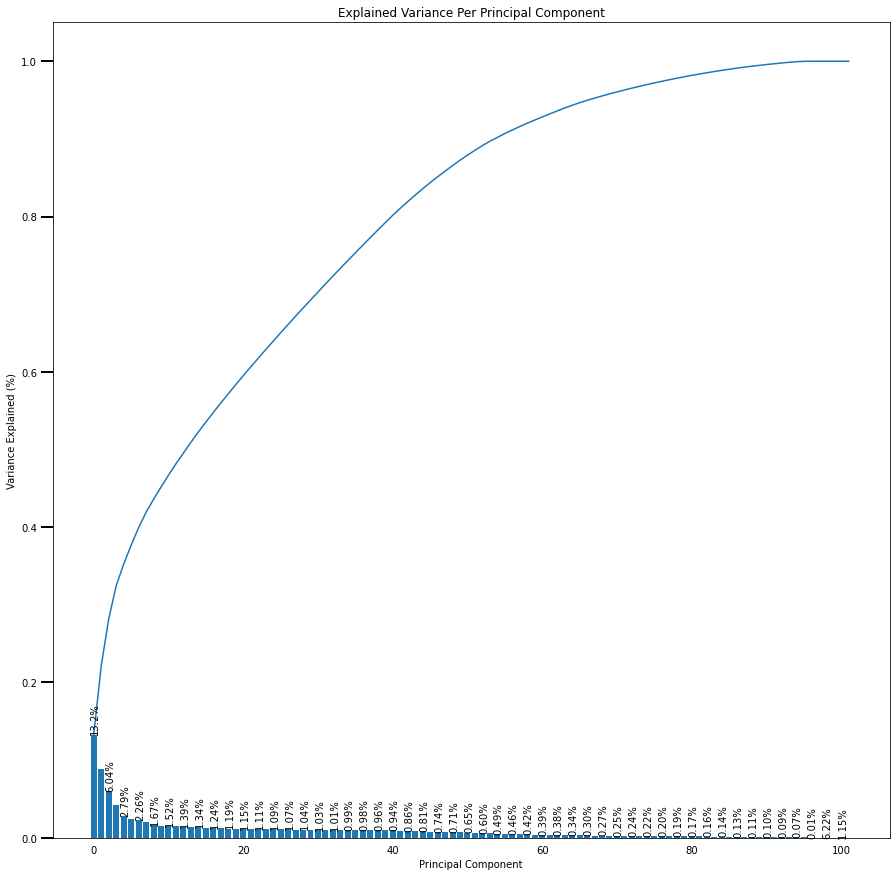

In [64]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(0, num_components, 2):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10, rotation=90)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')
plt.show()

In [65]:
# get ncomp where cumulative variance is greater than 90%

s = list(cumvals)
n_comp = next(i for i, x in enumerate(s) if x >= 0.9)
print(n_comp)

54


In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_2 = PCA(n_components=n_comp)
azdias_pca_2 = pca_2.fit_transform(azdias_sca)

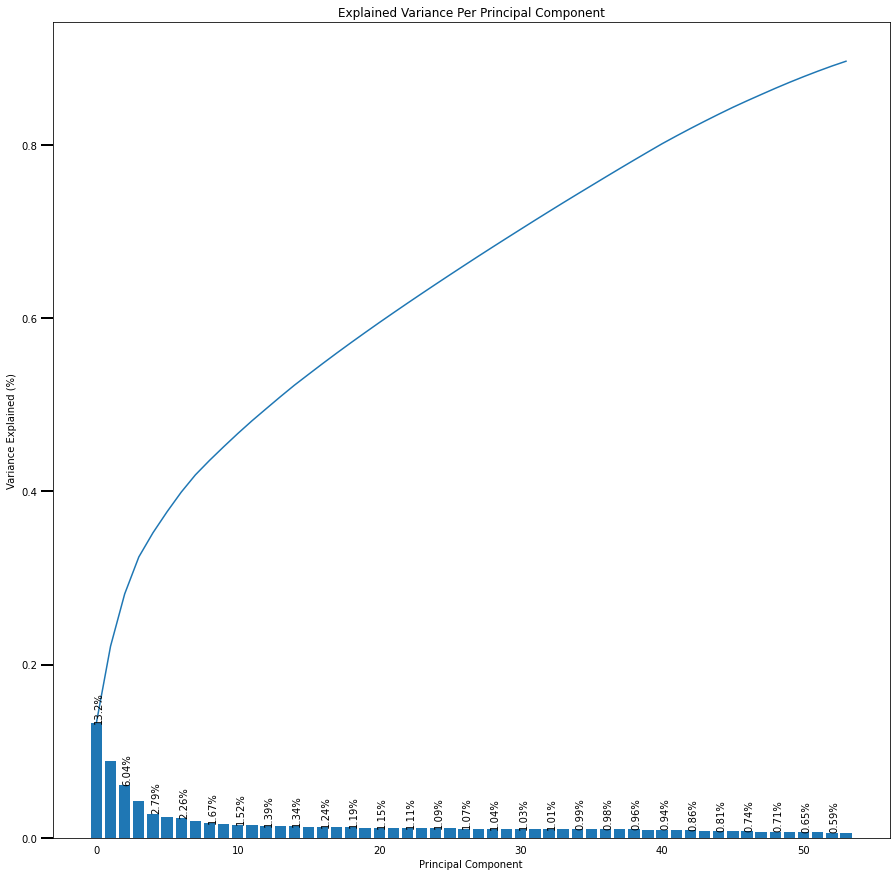

In [67]:
# Plot new variance

num_components = len(pca_2.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca_2.explained_variance_ratio_

plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(0, num_components, 2):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10, rotation=90)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

Retaining just over half of the features maintains a variance of 90%, which is a good amount of information retention whlist significantly reducing the dimensionality.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [68]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def feature_weights(component, dataframe):
    weights = pd.DataFrame({'Feature_Name':dataframe.columns, 'Weight':pca_2.components_[component]})
    weights = weights.sort_values(by=['Weight'], ascending=False)
    weights_lim = weights.head(3)
    weights_lim = weights_lim.append(weights.tail(3))
    return weights_lim

In [69]:
feature_weights(0, test_dfclean)

,Feature_Name,Weight
54,PLZ8_ANTG3,0.207717
79,LP_STATUS_GROB_1,0.204164
55,PLZ8_ANTG4,0.201762
38,KBA05_ANTG1,-0.203819
52,PLZ8_ANTG1,-0.206985
48,MOBI_REGIO,-0.218108


In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_weights(1, test_dfclean)

,Feature_Name,Weight
0,ALTERSKATEGORIE_GROB,0.269881
4,FINANZ_VORSORGER,0.243924
17,SEMIO_ERL,0.225882
3,FINANZ_SPARER,-0.254088
94,PRAEGENDE_JUGENDJAHRE_DECADE,-0.254562
13,SEMIO_REL,-0.261778


In [71]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_weights(2, test_dfclean)

,Feature_Name,Weight
15,SEMIO_VERT,0.347299
11,SEMIO_SOZ,0.266698
12,SEMIO_FAM,0.258027
21,SEMIO_DOM,-0.308475
22,SEMIO_KAEM,-0.337142
1,ANREDE_KZ,-0.368487


### Discussion 2.3: Interpret Principal Components

For the first principal component, PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), LP_STATUS_GROB_1 (low-income earners) and PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) have strongly positive weights. MOBI_REGIO (Movement patterns), PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region) and KBA05_ANTG1 (Number of 1-2 family houses in the microcell) have strongly negative weights. This suggests increases in family household size leads to increase in low-income earners and increases in movement patterns relate to increases in smaller family household size. Conversely, low-income earners and large family household sizes appear to be inversely related. 

For the second principal component, ALTERSKATEGORIE_GROB (Estimated age based on given name analysis young (1) to old (4)),  FINANZ_VORSORGER (Financial typology - be prepared - high (1) to low (5)) and SEMIO_ERL (Personality typology - event-oriented - high (1) to low (5)) have strongly positive weights. SEMIO_REL (Personality typology - religious - high (1) to low (7)), PRAEGENDE_JUGENDJAHRE_DECADE (Decade of youth - 40 (1940s) to 90 (1990s)) and FINANZ_SPARER (Financial typology - money-saver - high (1) to low (5)) have strongly negative weights. The inverse relationship between ALTERSKATEGORIE_GROB (young to old) and PRAEGENDE_JUGENDJAHRE_DECADE (old to young) suggests this component has relevance. Increases in age appear to reduce the propensity for saving. Furthermore, increases in age appear to increase the propensity toward religious views. 

For the final third principal component, SEMIO_VERT (Personality - dreamful - high (1) to low (7)), SEMIO_SOZ (Personality - socially-minded - high (1) to low (7)) and SEMIO_FAM (Personality - family-minded - high (1) to low (7)) have strongly positive weights. ANREDE_KZ (Gender - male (1) to female (2)), SEMIO_KAEM (Personality - combative - high (1) to low (7)) and SEMIO_DOM (Personality - dominant - high (1) to low (7)) have strongly negative weights. The relationships in this component appear quite clear; dreamful and socially-minded personalities are inversely related to combative and dominant personalities.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
scores = pd.DataFrame(columns = ['KMeans', 'Score'])

# Over a number of different cluster counts...
for i in range(2,30,2):
    
    # run k-means clustering on the data and...
    km = KMeans(n_clusters = i) 
    mod = km.fit(azdias_pca_2)
        
    # compute the average within-cluster distances.
    score = np.abs(mod.score(azdias_pca_2))
    
    # append scores to df
    data = {'KMeans':[i], 'Score':[score]}
    df = pd.DataFrame(data)
    scores = scores.append(df)

print (scores)

  KMeans         Score
0      2  6.057396e+07
0      4  5.523890e+07
0      6  5.230544e+07
0      8  5.034571e+07
0     10  4.907843e+07
0     12  4.813507e+07
0     14  4.703718e+07
0     16  4.645753e+07
0     18  4.557522e+07
0     20  4.481293e+07
0     22  4.415853e+07
0     24  4.388393e+07
0     26  4.336955e+07
0     28  4.301673e+07


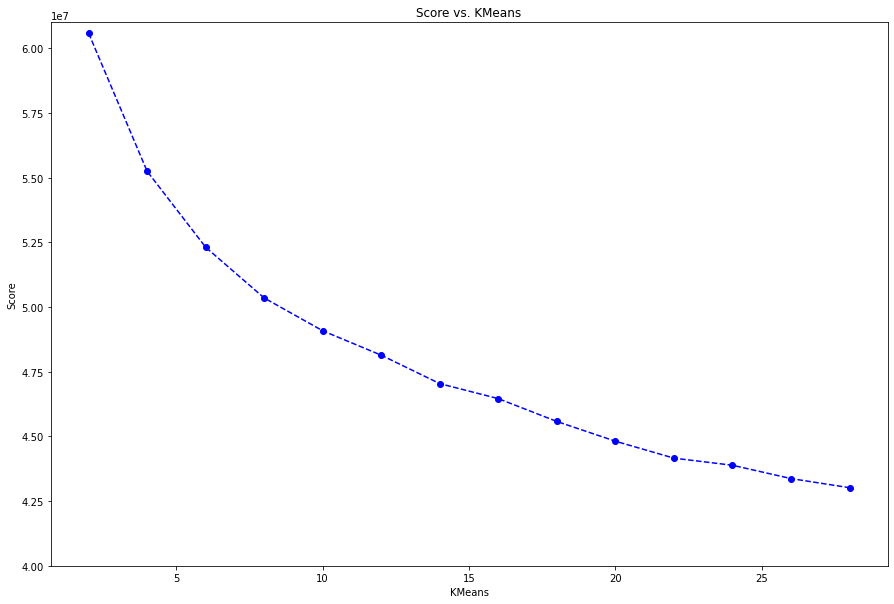

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(15, 10))
plt.plot('KMeans', 'Score', data=scores, linestyle='--', marker='o', color='b')
plt.xlabel('KMeans')
plt.ylim(40000000,61000000)
plt.ylabel('Score')
plt.title('Score vs. KMeans')
plt.show()

In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

km = KMeans(n_clusters = 14)
azdias_mod = km.fit_predict(azdias_pca_2)

### Discussion 3.1: Apply Clustering to General Population

There is a levelling off of the Sum of Squared Errors at a KMeans of 14. This suggests adding more clusters beyond 14 clusters does not significantly reduce the average distance from the points and therefore 14 clusters should be used.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [75]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [76]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply preprocessing
customers_clean = clean_data(customers)
customers_clean.shape

C:\Apps\Continuum\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(188439, 43)

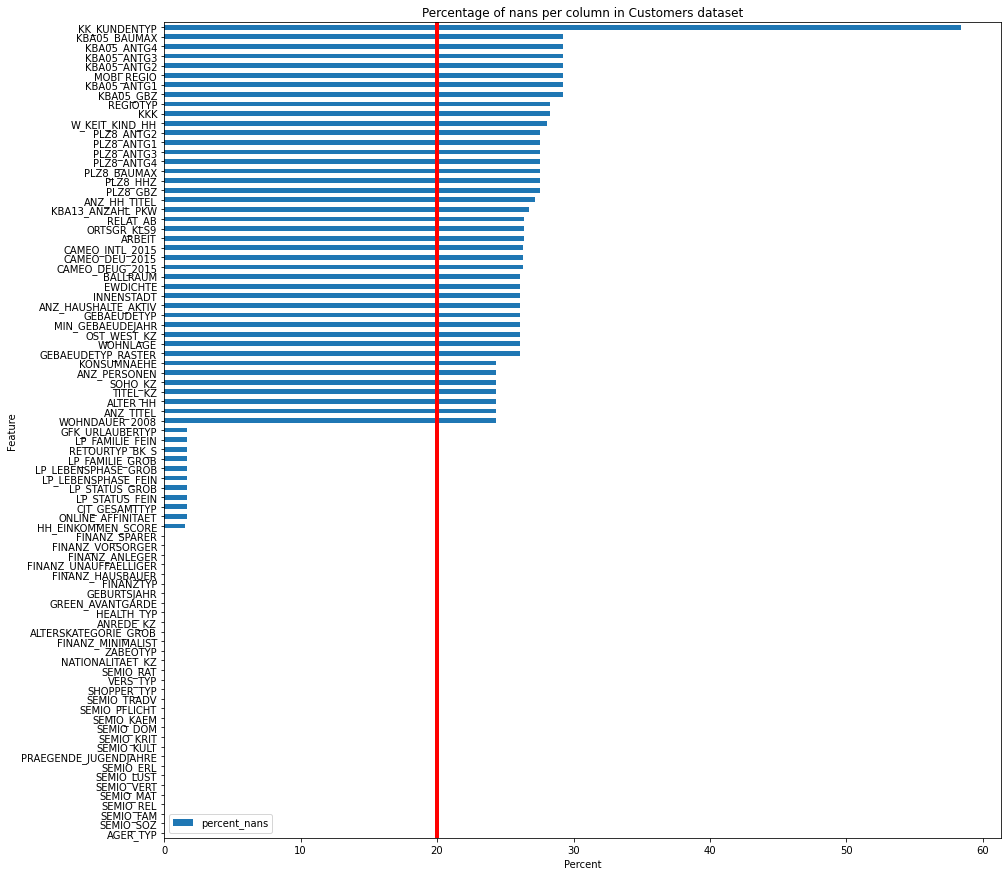

In [77]:
# Too many columns dropped in clean_data section relating to columns dropped by percentage nan
# Threashold for Azdias data was 20%
# How many columns in Customer data with more than 20% nans?

missdat = customers.isnull().sum().to_frame()
missdat = missdat.rename(columns={0: "number_nans"})
missdat['percent_nans'] = (missdat['number_nans']/customers.shape[0])*100
missdat = missdat.sort_values('percent_nans')

# plot
missdatd = missdat[['percent_nans']]
missdatd.plot.barh(figsize=(15, 15))
plt.axvline(x=20,linewidth=4, color='r')
pltlab('Percentage of nans per column in Customers dataset','Percent','Feature')

In the Azdias dataset, columns with greater than 20% nan values numbered six including AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX. However, almost half of the Customers dataset has more than 20% nan values. Therefore the def clean_data is not applicable to the Customers dataset in its entirety. 

The columns which were removed from the Azdias dataset will be removed from the Customers dataset and the rest of the def clean_data will be run below:

In [78]:
def clean_data_customers(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Copy input to new df
    dfcopy = df.copy()
    
    # Load feat_info
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i in range(len(feat_info)):
        colname = feat_info.iloc[i, 0]
        a = feat_info.iloc[i, 3]
        b = pd.DataFrame([a])
        b[0] = b[0].map(lambda x: x.lstrip('[').rstrip(']'))
        b = b[0].str.split(',', expand=True)
        b = b.transpose()
        for j in range(len(b)):
            c = b.iloc[j, 0]
            if c.isnumeric() or c.lstrip('-').isnumeric():
                c = int(c)
            dfcopy.loc[dfcopy[colname] == c, colname] = np.nan
    
    # remove selected columns and rows, ...
  #############################  
    # Remove columns with more than 20% of missing data
    #missdat = dfcopy.isnull().sum().to_frame()
    #missdat = missdat.rename(columns={0: "number_nans"})
    #missdat['percent_nans'] = (missdat['number_nans']/dfcopy.shape[0])*100
    #coloutlier = missdat[(missdat['percent_nans'] > 20)]
    #coloutlier = coloutlier.index.to_list()
    #for col in coloutlier:
    #    dfcopy.drop([col], axis=1, inplace=True)
  ############################

    # remove rows with more than 10% of missing data
    missdatr = dfcopy.isnull().sum(axis=1).to_frame()
    missdatr = missdatr.rename(columns={0: "number_nans"})
    missdatr['percent_nans'] = (missdatr['number_nans']/dfcopy.shape[1])*100
    missdatrone = missdatr[(missdatr['percent_nans'] <= 10)]
    dfcopy = dfcopy[dfcopy.index.isin(missdatrone.index)]
    
    # select, re-encode, and engineer column values.
    
    # Re-Encode Categorical Features to be kept
    # Re-encode GFK_URLAUBERTYP, LP_FAMILIE_GROB, LP_STATUS_GROB and CAMEO_DEUG_2015 using pd.get_dummies
    col = ['GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015']
    cols = []
    for c in col:
        if c in (list(dfcopy)):
            cols.append(c)
    renc = dfcopy[cols]
    renc = renc[cols].fillna(0.0).astype(int)
    dfcopy_renc = pd.get_dummies(data=renc, columns=cols)
    dfcopy = pd.concat([dfcopy, dfcopy_renc], axis=1, sort=False)

    # Re-encode GEBAEUDETYP to be kept in the analysis
    if 'GEBAEUDETYP' in (list(dfcopy)):
        GEBAEUDETYP_d = {1.0: 1, 2.0: 1, 3.0: 3, 4.0: 3, 5.0: 3, 6.0: 3, 7.0: 3, 8.0: 3}
        dfcopy['GEBAEUDETYP'] = dfcopy['GEBAEUDETYP'].map(GEBAEUDETYP_d)
    
    # Re-encode OST_WEST_KZ to be kept in the analysis
    if 'OST_WEST_KZ' in (list(dfcopy)):
        OST_WEST_KZ_d = {'W': 1, 'O': 2}
        dfcopy['OST_WEST_KZ'] = dfcopy['OST_WEST_KZ'].map(OST_WEST_KZ_d)
    
    # Engineer PRAEGENDE_JUGENDJAHRE to be kept in the analysis
    if 'PRAEGENDE_JUGENDJAHRE' in (list(dfcopy)):
        PRAEGENDE_JUGENDJAHRE_DECADE_d = {1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60, 8.0:70, 
                                          9.0:70, 10.0:80, 11.0:80,12.0:80, 13.0:80, 14.0:90, 15.0:90}
        dfcopy['PRAEGENDE_JUGENDJAHRE_DECADE'] = dfcopy['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_DECADE_d)
        PRAEGENDE_JUGENDJAHRE_MOVEMENT_d = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1,
                                            13.0:2, 14.0:1, 15.0:2}
        dfcopy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dfcopy['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_MOVEMENT_d)
        
    # Engineer CAMEO_INTL_2015 to be kept in the analysis
    if 'CAMEO_INTL_2015' in (list(dfcopy)):
        dfcopy['CAMEO_INTL_2015_WEALTH'] = dfcopy['CAMEO_INTL_2015'].str[:1]
        dfcopy['CAMEO_INTL_2015_STAGE'] = dfcopy['CAMEO_INTL_2015'].str[1:]
    
    # Engineer WOHNLAGE to be kept in the analysis
    if 'WOHNLAGE' in (list(dfcopy)):
        WOHNLAGE_NEIGHBORHOOD_d = {0.0:0,1.0:1,2.0:2,3.0:3,4.0:4,5.0:5,7.0:0,8.0:0}
        dfcopy['WOHNLAGE_NEIGHBORHOOD'] = dfcopy['WOHNLAGE'].map(WOHNLAGE_NEIGHBORHOOD_d)
        WOHNLAGE_RURAL_d = {0.0:0,1.0:0,2.0:0,3.0:0,4.0:0,5.0:0,7.0:7,8.0:7}
        dfcopy['WOHNLAGE_RURAL'] = dfcopy['WOHNLAGE'].map(WOHNLAGE_RURAL_d)
    
    # Engineer PLZ8_BAUMAX to be kept in the analysis
    if 'PLZ8_BAUMAX' in (list(dfcopy)):
        PLZ8_BAUMAX_FAMILY_HOMES_d = {1.0:1,2.0:2,3.0:3,4.0:4,5.0:0}
        PLZ8_BAUMAX_BUSINESS_BUILDINGS_d = {1.0:0,2.0:0,3.0:0,4.0:0,5.0:5}
        dfcopy['PLZ8_BAUMAX_FAMILY_HOMES'] = dfcopy['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_FAMILY_HOMES_d)
        dfcopy['PLZ8_BUSINESS_BUILDINGS'] = dfcopy['PLZ8_BAUMAX'].map(PLZ8_BAUMAX_BUSINESS_BUILDINGS_d)
    
    # Drop other un-wanted attributes from main dataset
    drop = ['CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP',
            'CAMEO_DEU_2015','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','PLZ8_BAUMAX','WOHNLAGE','CAMEO_INTL_2015',
            'PRAEGENDE_JUGENDJAHRE','GFK_URLAUBERTYP','LP_STATUS_GROB','LP_FAMILIE_GROB','CAMEO_DEUG_2015', 'AGER_TYP', 
            'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for dro in drop:
        if dro in (list(dfcopy)):
            dfcopy.drop([dro], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return dfcopy   

In [79]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply preprocessing
customers_clean = clean_data_customers(customers)
customers_clean.shape

(128298, 102)

In [80]:
# Apply imputer and feature scaling
customers_clean_imp = imp.transform(customers_clean)
customers_clean_sca = scaler.transform(customers_clean_imp)

In [81]:
# Apply Dimensionality Reduction
customers_clean_pca_2 = pca_2.transform(customers_clean_sca)
# Obtain cluster predictions
customers_mod = km.predict(customers_clean_pca_2)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

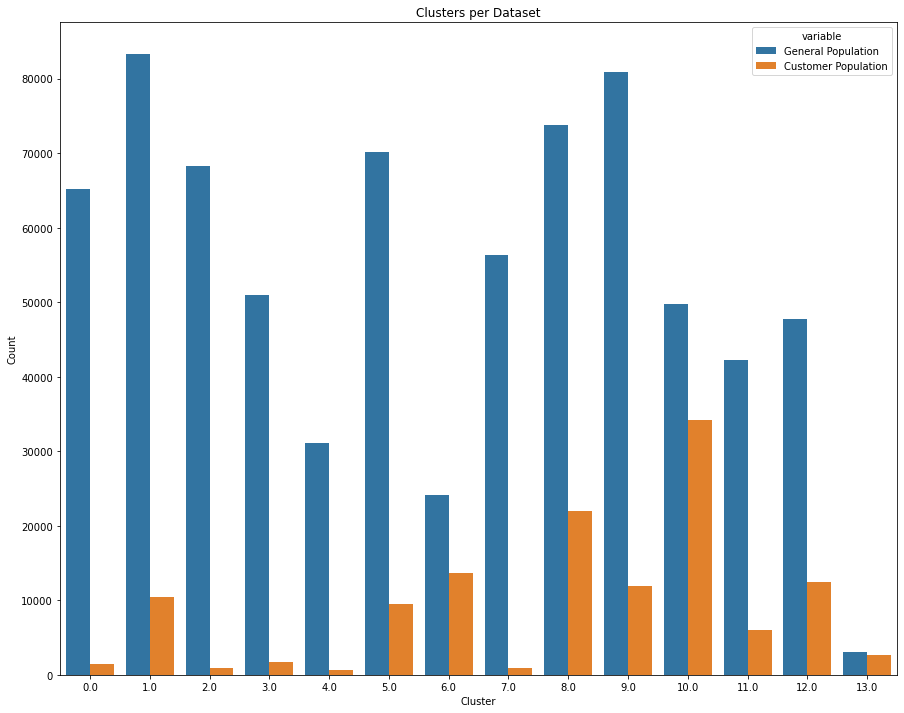

In [82]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# capture data
clust_prop1 = pd.DataFrame({'General Population': azdias_mod})
clust_prop2 = pd.DataFrame({'Customer Population': customers_mod})
clust_prop = pd.concat([clust_prop1, clust_prop2], axis=1, sort=False)

# plot in countplot
plt.figure(figsize=(15,12))
clrs = ['blue', 'orange']
sb.countplot(x='value', hue='variable', data=pd.melt(clust_prop))
pltlab('Clusters per Dataset','Cluster','Count')
plt.show()

<Figure size 1080x864 with 0 Axes>

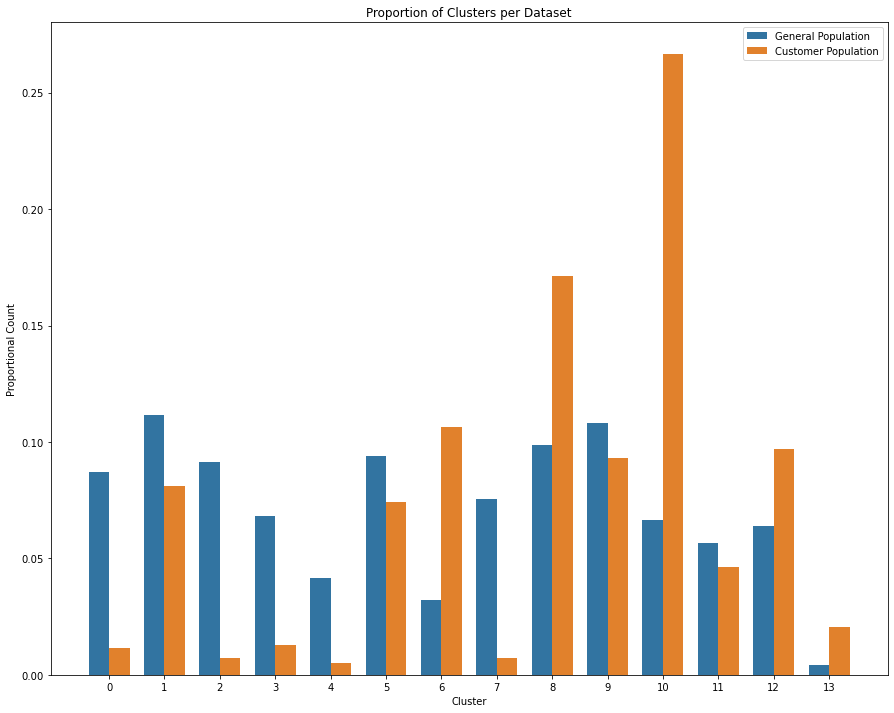

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# capture data proportions
clust_prop['Gen Pop Prop'] = (clust_prop.groupby('General Population')['General Population'].transform('count'))/len(azdias_mod)
clust_prop['Cust Pop Prop'] = (clust_prop.groupby('Customer Population')['Customer Population'].transform('count'))/len(customers_mod)

gen_prop = clust_prop[['General Population', 'Gen Pop Prop']].drop_duplicates('General Population')
cust_prop = clust_prop[['Customer Population', 'Cust Pop Prop']].drop_duplicates('Customer Population')
cust_prop = cust_prop.dropna()

gen_props = gen_prop.sort_values(by=['General Population']).reset_index(drop=True)
cust_props = cust_prop.sort_values(by=['Customer Population']).reset_index(drop=True)

# plot data
labels = gen_props['General Population']
gen_proper = gen_props['Gen Pop Prop']
cust_proper= cust_props['Cust Pop Prop']

plt.figure(figsize=(15,12))
x = np.arange(len(labels))
width = 0.37
fig, ax = plt.subplots(figsize=(15,12))
bar1 = ax.bar(x - width/2, gen_proper, width, label='General Population', color='#3274A1')
bar2 = ax.bar(x + width/2, cust_proper, width, label='Customer Population', color='#E1812C')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
pltlab('Proportion of Clusters per Dataset','Cluster','Proportional Count')
ax.legend()
plt.show()

In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# calculate largest differences between the general and customer population representation
props = pd.concat([gen_props, cust_props], axis=1, sort=False)
props['Cust Overep'] = props['Cust Pop Prop'] / props['Gen Pop Prop']
cust_overep = props['General Population'].loc[props['Cust Overep'].idxmax()]
print("The largest overepresentation of customer data is in cluster:", cust_overep)

The largest overepresentation of customer data is in cluster: 13


In [85]:
# Inverse Transform to original data space
overep = pd.DataFrame(scaler.inverse_transform(pca_2.inverse_transform(customers_clean_pca_2[np.where(customers_mod==cust_overep)])), columns=customers_clean.columns)

In [86]:
# identify key features 
feature_weights(cust_overep, overep)

,Feature_Name,Weight
100,PLZ8_BAUMAX_FAMILY_HOMES,0.310436
9,HEALTH_TYP,0.243488
10,RETOURTYP_BK_S,0.149641
37,OST_WEST_KZ,-0.225034
58,ARBEIT,-0.248788
50,REGIOTYP,-0.256457


In [87]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# calculate largest differences between the general and customer population representation
props['Cust Underep'] = props['Gen Pop Prop'] / props['Cust Pop Prop']
cust_underep = props['General Population'].loc[props['Cust Underep'].idxmax()]
print("The largest underepresentation of customer data is in cluster:", cust_underep)

The largest underepresentation of customer data is in cluster: 2


In [88]:
# Inverse Transform to original data space
undrep = pd.DataFrame(scaler.inverse_transform(pca_2.inverse_transform(customers_clean_pca_2[np.where(customers_mod==cust_underep)])), columns=customers_clean.columns)

In [89]:
# identify key features 
feature_weights(cust_underep, undrep)

,Feature_Name,Weight
15,SEMIO_VERT,0.347299
11,SEMIO_SOZ,0.266698
12,SEMIO_FAM,0.258027
21,SEMIO_DOM,-0.308475
22,SEMIO_KAEM,-0.337142
1,ANREDE_KZ,-0.368487


### Discussion 3.3: Compare Customer Data to Demographics Data

The majority of the clusters had reasonably similar representation between the General and Customer populations. 

Cluster 9 was an anomalous cluster which overrepresented the customer population compared to the general population. Using the largest weights of the features within the dataset, it can be identified that the typical customer is rational and traditionally-minded. 

Cluster 12 was an anomalous cluster which underrepresented the customer population compared to the general population. Using the largest weights of the features within the dataset, it can be identified that the typical customer is independent.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.